In [6]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.interpolate import RectBivariateSpline

# Define the x-y grid
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])

# Define GP kernel and sample surface
kernel = 0.1**2 * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)
Z_sample = gp.sample_y(XY, n_samples=1).reshape(50, 50)

# Create 2D spline interpolator
gp_surface = RectBivariateSpline(x, y, Z_sample)77

np.savetxt("gp_surface_z.csv", Z_sample, delimiter=",")
np.savetxt("gp_surface_x.csv", x, delimiter=",")
np.savetxt("gp_surface_y.csv", y, delimiter=",")


In [8]:
# Simulation parameters
resolution = 10  # pixels/um
pml_thickness = 2
cell_x = 16
cell_y = 16
cell_z = 16

sphere_radius = 1.0
sphere_eps = 2.56
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 10  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)



In [9]:
# Materials
substrate_material = mp.Medium(epsilon=substrate_eps)
def gp_surface_material(p):
    z_surface = gp_surface(p.x, p.y)[0, 0]  # interpolate GP surface height at (x, y)
    return substrate_material if p.z < z_surface else mp.air


# Source: downward plane wave at angles
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),
        direction=mp.Z,  # still Z, but mode defines propagation
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True
    )
]


# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources, # you can still add discrete objects
    default_material=gp_surface_material
)


# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00108504 s


Working in 3D dimensions.
Computational cell is 16 x 16 x 16 with resolution 10
subpixel-averaging is 86.9863% done, 0.600104 s remaining
subpixel-averaging is 96.9368% done, 0.126583 s remaining
subpixel-averaging is 26.6443% done, 11.0163 s remaining
subpixel-averaging is 47.1765% done, 4.48953 s remaining
subpixel-averaging is 68.1834% done, 1.86838 s remaining
subpixel-averaging is 88.3002% done, 0.531034 s remaining
subpixel-averaging is 98.2208% done, 0.0725941 s remaining
subpixel-averaging is 18.5145% done, 17.6287 s remaining
subpixel-averaging is 35.9016% done, 7.18892 s remaining
subpixel-averaging is 53.9414% done, 3.42301 s remaining
subpixel-averaging is 79.221% done, 1.05076 s remaining
subpixel-averaging is 96.7861% done, 0.133057 s remaining
subpixel-averaging is 83.4555% done, 0.795931 s remaining
subpixel-averaging is 92.7641% done, 0.312466 s remaining
subpixel-averaging is 17.565% done, 18.7796 s remaining
subpixel-averaging is 36.317% done, 7.01515 s remaining
sub

Flux through top: 34.188523
Flux through bottom: -259.724187
Flux through left: -0.727287
Flux through right: -7.114631
Flux through front: 3.644281
Flux through back: -3.862106


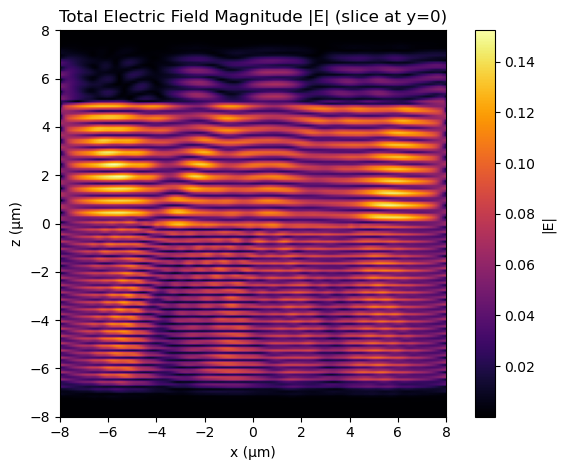

In [10]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Get all field components for total |E| calculation
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ez)

abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# Plot total field magnitude
plt.figure(dpi=100)
plt.imshow(abs_E.T, cmap='inferno', origin='lower', extent=[-cell_x/2, cell_x/2, -cell_z/2, cell_z/2])
plt.colorbar(label='|E|')
plt.xlabel('x (µm)')
plt.ylabel('z (µm)')
plt.title('Total Electric Field Magnitude |E| (slice at y=0)')
plt.tight_layout()
plt.show()